In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [15]:
SPY = pd.read_csv('SPY.new.csv')
SPY['Date'] = pd.to_datetime(SPY['Date'])  # Convert 'Date' column to datetime
SPY = SPY.set_index('Date')
SPY

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,384.369995,386.429993,377.829987,380.820007,375.118744,74850700
2023-01-04,383.179993,385.880005,380.000000,383.760010,378.014709,85934100
2023-01-05,381.720001,381.839996,378.760010,379.380005,373.700256,76970500
2023-01-06,382.609985,389.250000,379.410004,388.079987,382.269989,104189600
2023-01-09,390.369995,393.700012,387.670013,387.859985,382.053284,73978100
...,...,...,...,...,...,...
2024-01-02,472.160004,473.670013,470.489990,472.649994,472.649994,123623700
2024-01-03,470.429993,471.190002,468.170013,468.790009,468.790009,103585900
2024-01-04,468.299988,470.959991,467.049988,467.279999,467.279999,84232200


<function matplotlib.pyplot.show(close=None, block=None)>

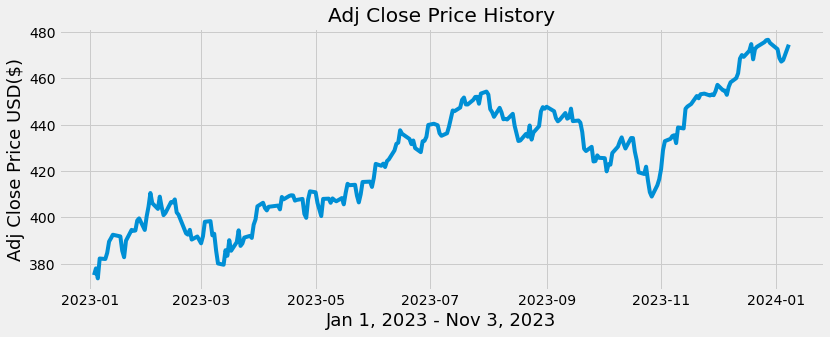

In [16]:
plt.figure(figsize=(12.2,4.5))
plt.plot(SPY.index, SPY['Adj Close'],label = 'Adj Close Price')
plt.title ('Adj Close Price History')
plt.xlabel ('Jan 1, 2023 - Nov 3, 2023', fontsize = 18)
plt.ylabel ('Adj Close Price USD($)', fontsize = 18)
plt.show

In [17]:
delta = SPY['Adj Close'].diff(1)
delta = delta.dropna()
delta

Date
2023-01-04    2.895965
2023-01-05   -4.314453
2023-01-06    8.569733
2023-01-09   -0.216705
2023-01-10    2.679290
                ...   
2024-01-02   -2.660004
2024-01-03   -3.859985
2024-01-04   -1.510010
2024-01-05    0.640014
2024-01-08    6.679993
Name: Adj Close, Length: 254, dtype: float64

In [18]:
up = delta.copy()
down = delta.copy()

up[up<0] = 0
down[down>0] = 0

In [19]:
period = 14

AVG_Gain = up.rolling(window=period).mean()
AVG_Loss = abs(down.rolling(window=period).mean())

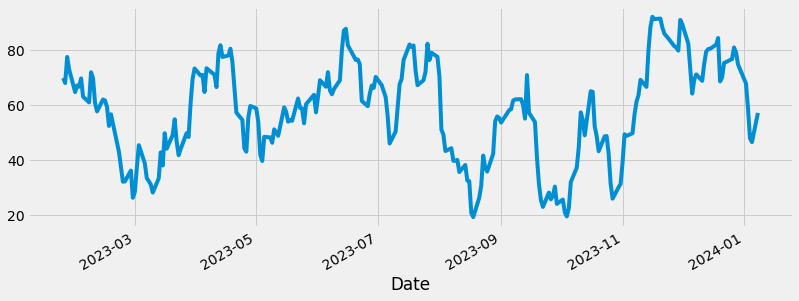

In [20]:
RS = AVG_Gain / AVG_Loss
RSI = 100-(100/(1+RS))
RSI = RSI

plt.figure(figsize = (12.2,4.5))
RSI.plot()
plt.show()

In [21]:
new_df = pd.DataFrame()
new_df['Adj Close'] = SPY['Adj Close']
new_df['RSI'] = RSI
new_df.columns = ['Close','RSI']
new_df= new_df.dropna()
new_df

,Close,RSI
Date,,
2023-01-24,394.208557,69.711115
2023-01-25,394.356323,67.888707
2023-01-26,398.690430,77.344278
2023-01-27,399.606506,72.786154
2023-01-30,394.592712,64.635573
...,...,...
2024-01-02,472.649994,67.734747
2024-01-03,468.790009,58.853108
2024-01-04,467.279999,47.950660


In [22]:
ShortEMA = new_df.Close.ewm(span=12, adjust = False).mean()
LongEMA = new_df.Close.ewm(span=26, adjust = False).mean()
MACD = ShortEMA - LongEMA 
signal = MACD.ewm(span=9, adjust = False).mean()
new_df['MACD'] = MACD
new_df['Signal Line'] = signal
new_df

,Close,RSI,MACD,Signal Line
Date,,,,
2023-01-24,394.208557,69.711115,0.000000,0.000000
2023-01-25,394.356323,67.888707,0.011788,0.002358
2023-01-26,398.690430,77.344278,0.366629,0.075212
2023-01-27,399.606506,72.786154,0.713538,0.202877
2023-01-30,394.592712,64.635573,0.577241,0.277750
...,...,...,...,...
2024-01-02,472.649994,67.734747,7.204775,7.624360
2024-01-03,468.790009,58.853108,6.431325,7.385753
2024-01-04,467.279999,47.950660,5.631598,7.034922


In [23]:
#function to signal when to buy and sell
def buy_sell (signal):
    buy = []
    sell = []
    flag = -1
    
    for i in range (0, len(signal)):
        if signal['MACD'][i]>signal['Signal Line'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append(signal['Close'][i])
                flag = 1
            else:
                buy.append(np.nan)
        elif signal['MACD'][i]<signal['Signal Line'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append(signal['Close'][i])
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return (buy,sell)

In [24]:
#create buy and sell columns
a = buy_sell(new_df)
new_df['buy_signal_price'] = a[0]
new_df['sell_signal_price'] = a[1]
new_df

,Close,RSI,MACD,Signal Line,buy_signal_price,sell_signal_price
Date,,,,,,
2023-01-24,394.208557,69.711115,0.000000,0.000000,NaN,NaN
2023-01-25,394.356323,67.888707,0.011788,0.002358,394.356323,NaN
2023-01-26,398.690430,77.344278,0.366629,0.075212,NaN,NaN
2023-01-27,399.606506,72.786154,0.713538,0.202877,NaN,NaN
2023-01-30,394.592712,64.635573,0.577241,0.277750,NaN,NaN
...,...,...,...,...,...,...
2024-01-02,472.649994,67.734747,7.204775,7.624360,NaN,NaN
2024-01-03,468.790009,58.853108,6.431325,7.385753,NaN,NaN
2024-01-04,467.279999,47.950660,5.631598,7.034922,NaN,NaN


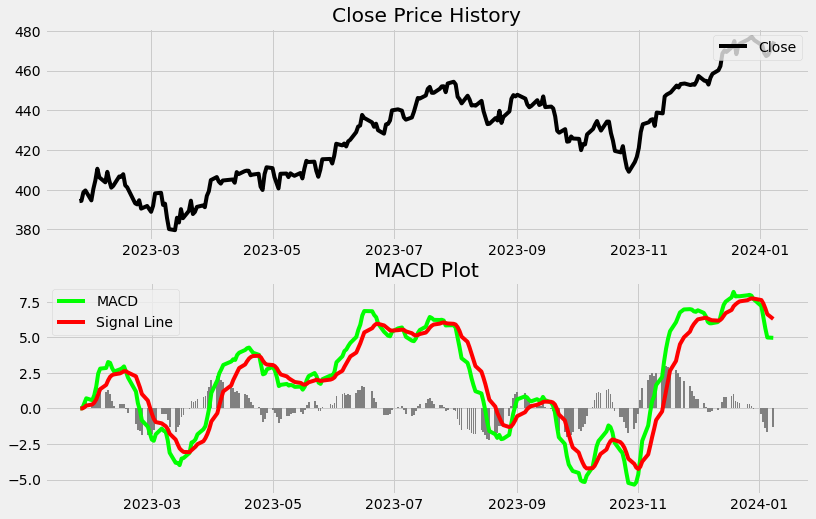

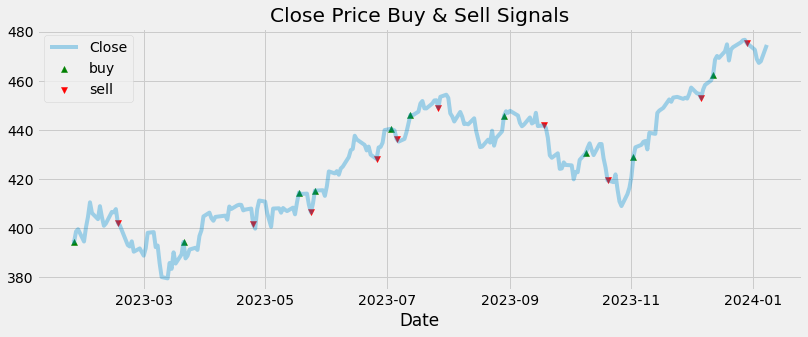

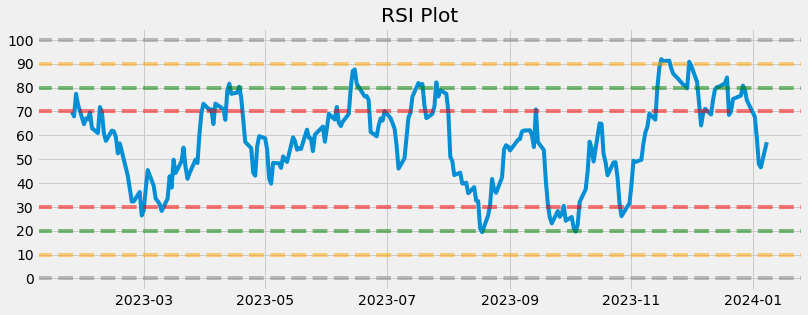

In [25]:
# Create a figure and axes for the entire plot
fig, ax = plt.subplots(2, 1, figsize=(12.2, 8))

# Plot Close Prices
ax[0].plot(new_df.index, new_df['Close'],color = 'black')
ax[0].set_title('Close Price History')
ax[0].legend(new_df.columns.values, loc='upper right')

ShortEMA = new_df.Close.ewm(span=12, adjust = False).mean()
LongEMA = new_df.Close.ewm(span=26, adjust = False).mean()
MACD = ShortEMA - LongEMA 
signal = MACD.ewm(span=9, adjust = False).mean()

# Plot MACD and Signal Line
ax[1].plot(new_df.index, MACD, label='MACD', color='lime')
ax[1].plot(new_df.index, signal, label='Signal Line', color='red')
ax[1].legend()

# Plot MACD Histogram
macd_histogram = MACD - signal
bar_width = 0.9
ax[1].bar(new_df.index, macd_histogram, label='MACD Histogram', color='grey', alpha=1, width=bar_width)
plt.title('MACD Plot')

#signals chart
plt.figure(figsize = (12.2, 4.5))
plt.scatter(new_df.index,new_df['buy_signal_price'],color = 'green',label ='buy',marker = '^',alpha = 1)
plt.scatter(new_df.index,new_df['sell_signal_price'],color = 'red',label ='sell',marker = 'v',alpha = 1)
plt.plot(new_df['Close'],label = 'Close',alpha = 0.35)
plt.title('Close Price Buy & Sell Signals')
plt.xlabel('Date')
plt.legend(loc ='upper left')
plt.show()

#plot corresponding RSI values and significant levels
plt.figure(figsize=(12.2,4.5))
plt.title('RSI Plot')
plt.plot(new_df.index,new_df['RSI'])
plt.axhline(0,linestyle ='--', alpha = 0.5, color = 'gray' )
plt.axhline(10,linestyle ='--', alpha = 0.5, color = 'orange' )
plt.axhline(20,linestyle ='--', alpha = 0.5, color = 'green' )
plt.axhline(30,linestyle ='--', alpha = 0.5, color = 'red' )
plt.axhline(70,linestyle ='--', alpha = 0.5, color = 'red' )
plt.axhline(80,linestyle ='--', alpha = 0.5, color = 'green' )
plt.axhline(90,linestyle ='--', alpha = 0.5, color = 'orange' )
plt.axhline(100,linestyle ='--', alpha = 0.5, color = 'gray' )
plt.yticks([0, 10, 20, 30, 40, 50,60,70,80,90,100])

plt.show()